In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import MultipleLocator

In [2]:
import plotly.express as px

In [3]:
book = pd.read_excel('your path\\booklist_1.0.xlsx', header = 0)
book['decade'] = 10*(book['时间']//10)
book1 = book[book.学科=='数学']
book2 = book1[['出版地', 'decade']].copy()
book3 = book2.groupby('出版地')['decade'].value_counts().rename('weight').reset_index()
B = nx.Graph()
B.add_nodes_from(book3['出版地'].to_numpy(), bipartite=0)
B.add_nodes_from(book3['decade'].to_numpy(), bipartite=1)
B.add_weighted_edges_from(book3.to_numpy())
city_nodes = {n for n, d in B.nodes(data=True) if d['bipartite'] == 0}
year_nodes = set(B) - city_nodes
degcity, degyear = bipartite.degrees(B, year_nodes, weight='weight')
degcity1 = pd.DataFrame(pd.DataFrame(degcity)[1].value_counts())
degyear1 = pd.DataFrame(pd.DataFrame(degyear)[1].value_counts())
degcity1['频率'] = degcity1[1]/degcity1[1].sum()
degyear1['频率'] = degyear1[1]/degyear1[1].sum()
degcity1.sort_index(inplace=True)
degyear1.sort_index(inplace=True)

In [4]:
#给城市编号
city_nodes1 = list(city_nodes)
city_nodes1.sort()
citylist = np.array(city_nodes1)
citynum = list(np.arange(len(city_nodes)))
city_dict = dict(zip(citynum,city_nodes1))

In [5]:
citylist1 = pd.DataFrame(citylist)
citylist1.columns = ['出版地']
degree_city = pd.DataFrame(degcity)
degree_city.columns = ['出版地','Degree']
degree_city1 = pd.merge(citylist1, degree_city, on='出版地')

In [6]:
#给时间编号
year_nodes1 = list(year_nodes)
year_nodes1.sort()
yearlist = np.array(year_nodes1)
yearnum = list(np.arange(len(year_nodes)))
year_dict = dict(zip(yearnum,year_nodes1))

In [7]:
yearlist1 = pd.DataFrame(yearlist)
yearlist1.columns = ['decade']
degree_year = pd.DataFrame(degyear)
degree_year.columns = ['decade','Degree']
degree_year1 = pd.merge(yearlist1, degree_year, on='decade')

In [8]:
RCA = np.zeros((len(city_nodes),len(year_nodes)))
for i in range(len(year_nodes)):
    goodsum = book3['weight'].sum()
    book4 = book3[book3.decade==yearlist[i]]
    goodsum_ = book4['weight'].sum()
    rca1 = goodsum_/goodsum
    for j in range(len(city_nodes)):
        book5 = book3[book3.出版地==citylist[j]]
        citygoodsum = book5['weight'].sum()
        book6 = book5[book5.decade==yearlist[i]]
        citygoodsum_ = book6['weight'].sum()
        rca2 = citygoodsum_/citygoodsum
        RCA[j, i] = rca2/rca1

In [9]:
RCA_ = RCA

In [10]:
RCA_[RCA_  > 1] = 1
RCA_[RCA_  < 1] = 0

In [11]:
N = 500
F = np.zeros((N,len(city_nodes)))
Q = np.zeros((N,len(year_nodes)))
F[0,:] = 1
Q[0,:] = 1

In [12]:
for i in range(N-1):
    for j in range(len(city_nodes)):
        F[i+1, j] = np.sum(RCA_[j,:]*Q[i,:])
    F[i+1, :] = F[i+1, :]/np.mean(F[i+1, :])
    for k in range(len(year_nodes)):
        Q[i+1, k] = np.sum(RCA_[:,k]*(1/F[i,:]))
    Q[i+1, :] = Q[i+1, :]/np.mean(Q[i+1, :])

In [13]:
F_city = pd.DataFrame(np.vstack((citylist,F[N-1,:]))).T
F_city.columns = ['出版地','适应度']
F_city['适应度'] = pd.to_numeric(F_city['适应度'],errors='coerce')
F_city = F_city.sort_values(by=['适应度'], ascending=False)

In [14]:
Q_year = pd.DataFrame(np.vstack((yearlist,Q[N-1,:]))).T
Q_year.columns = ['decade','复杂度']
Q_year['复杂度'] = pd.to_numeric(Q_year['复杂度'],errors='coerce')
Q_year = Q_year.sort_values(by=['复杂度'], ascending=False)

In [15]:
degree_city = pd.DataFrame(degcity)
degree_city.columns = ['出版地','Degree']
F_city.columns = ['出版地','Fitness']
city_rank = pd.merge(degree_city, F_city, on='出版地')
city_rank = city_rank.sort_values(by=['Degree','Fitness'], ascending=False)
city_rank['Degree_sort'] = np.arange(len(city_rank))
city_rank = city_rank.sort_values(by=['Fitness'], ascending=False)
city_rank['Fitness_sort'] = np.arange(len(city_rank))
city_rank1 = city_rank
city_rank1 = city_rank1.drop(['Fitness','Degree'],axis=1)
city_rank1.set_index(['出版地'], inplace=True)
city_ranklist = city_rank1.index
city_rank1.columns = [0,1]
city_rank1[0] = city_rank1[0]+1
city_rank1[1] = city_rank1[1]+1

In [16]:
city_rank1[2] = city_rank1[1] - city_rank1[0]
plot_x = np.linspace(-10, 10, 1000)
S = np.zeros((len(city_rank1),1000))
for i in range(len(city_rank1)):
    a = city_rank1[2][i]
    b = city_rank1[0][i]
    S[i] = a*(1/(1 + np.exp(-plot_x)))+ b
index_x = np.linspace(0, 1, 1000)
S1 = pd.DataFrame(S)
S1.columns = index_x
S1.index = city_rank1.index
S1 = S1.T
city_rank1 = city_rank1.T

In [17]:
cmap1 = plt.get_cmap('RdYlBu',lut=len(city_ranklist))

In [18]:
degree_year = pd.DataFrame(degyear)
degree_year.columns = ['decade','Degree']
Q_year.columns = ['decade','Complexity']
year_rank = pd.merge(degree_year, Q_year, on='decade')
year_rank = year_rank.sort_values(by=['Degree','Complexity'], ascending=False)
year_rank['Degree_sort'] = np.arange(len(year_rank))
year_rank = year_rank.sort_values(by=['Complexity'], ascending=False)
year_rank['Complexity_sort'] = np.arange(len(year_rank))
year_rank['s'] = 's'
year_rank['decade'] = year_rank['decade'].astype(str)
year_rank['decade1'] = year_rank[['decade', 's']].apply(lambda x: ''.join(x), axis=1)
year_rank1 = year_rank
year_rank1 = year_rank1.drop(['Complexity','Degree','decade','s'],axis=1)
year_rank1.set_index(['decade1'], inplace=True)
year_ranklist = year_rank1.index
year_rank1.columns = [0,1]
year_rank1[0] = year_rank1[0]+1
year_rank1[1] = year_rank1[1]+1

In [19]:
year_rank1[2] = year_rank1[1] - year_rank1[0]
plot_x1 = np.linspace(-10, 10, 1000)
S2 = np.zeros((len(year_rank1),1000))
for i in range(len(year_rank1)):
    a = pd.array(year_rank1[2])[i]
    b = pd.array(year_rank1[0])[i]
    S2[i] = a*(1/(1 + np.exp(-plot_x1)))+ b
index_x1 = np.linspace(0, 1, 1000)
S3 = pd.DataFrame(S2)
S3.columns = index_x1
S3.index = year_rank1.index
S3 = S3.T
year_rank1 = year_rank1.T

In [20]:
cmap2 = plt.get_cmap('RdYlBu',lut=len(year_ranklist))

In [21]:
F_city1 = F_city.head(10)
Q_year1 = Q_year.head(10)

In [22]:
book4 = pd.merge(book3, F_city1, on='出版地')
book5 = pd.merge(book4, Q_year1, on='decade')
book6 = book5[['出版地','decade','weight']]
B_10 = nx.Graph()
B_10.add_nodes_from(book6['出版地'].to_numpy(), bipartite=0)
B_10.add_nodes_from(book6['decade'].to_numpy(), bipartite=1)
B_10.add_weighted_edges_from(book6.to_numpy())
city_10_nodes = {n for n, d in B_10.nodes(data=True) if d['bipartite'] == 0}
year_10_nodes = set(B) - city_10_nodes
city_10_nodes = set(F_city1['出版地'])
year_10_nodes = set(Q_year1['decade'])
F_city_dict = dict(zip(F_city1['出版地'], F_city1['Fitness']))
Q_year_dict = dict(zip(Q_year1['decade'], Q_year1['Complexity']))
nx.set_node_attributes(B_10, F_city_dict, '复杂度')
nx.set_node_attributes(B_10, Q_year_dict, '复杂度')

In [23]:
F_city1 = city_rank1.T.head(10)
Q_year1 = year_rank1.T.head(10)
book7 = pd.merge(book6, F_city1, left_on='出版地', right_index=True)
book7['s'] = 's'
book7['decade'] = book7['decade'].astype(str)
book7['decade1'] = book7[['decade', 's']].apply(lambda x: ''.join(x), axis=1)
book8 = pd.merge(book7, Q_year1, left_on='decade1', right_index=True)
book8 = book8.drop(['0_x','2_x','0_y','s','2_y'],axis=1)
book8.rename(columns={'1_x':'0','1_y':'1'},inplace=True)
book8.index = np.arange(len(book8))

In [24]:
cmap3 = plt.get_cmap('Pastel1',lut=len(book8['weight'].value_counts()))

In [25]:
plt.rcParams.update({'font.family':'sans-serif'})
plt.rcParams.update({'font.sans-serif':'Helvetica'})

In [26]:
import scipy.sparse

In [27]:
A10 = scipy.sparse.csr_matrix(RCA_)
G10 = bipartite.from_biadjacency_matrix(A10)
G10_edges = nx.to_pandas_edgelist(G10)
G10_edges['target'] = G10_edges['target']-len(citylist1)
G10 = pd.merge(G10_edges, citylist1, left_on='source', right_index=True)
G100 = pd.merge(G10, yearlist1, left_on='target', right_index=True)
G1000 = pd.merge(G100, F_city1, left_on='出版地', right_index=True)
G1000['s'] = 's'
G1000['decade'] = G1000['decade'].astype(str)
G1000['decade1'] = G1000[['decade', 's']].apply(lambda x: ''.join(x), axis=1)
G10000 = pd.merge(G1000, Q_year1, left_on='decade1', right_index=True)
G10000 = G10000.drop(['0_x','2_x','0_y','s','2_y'],axis=1)
G10000.rename(columns={'1_x':'0','1_y':'1'},inplace=True)
G10000.index = np.arange(len(G10000))

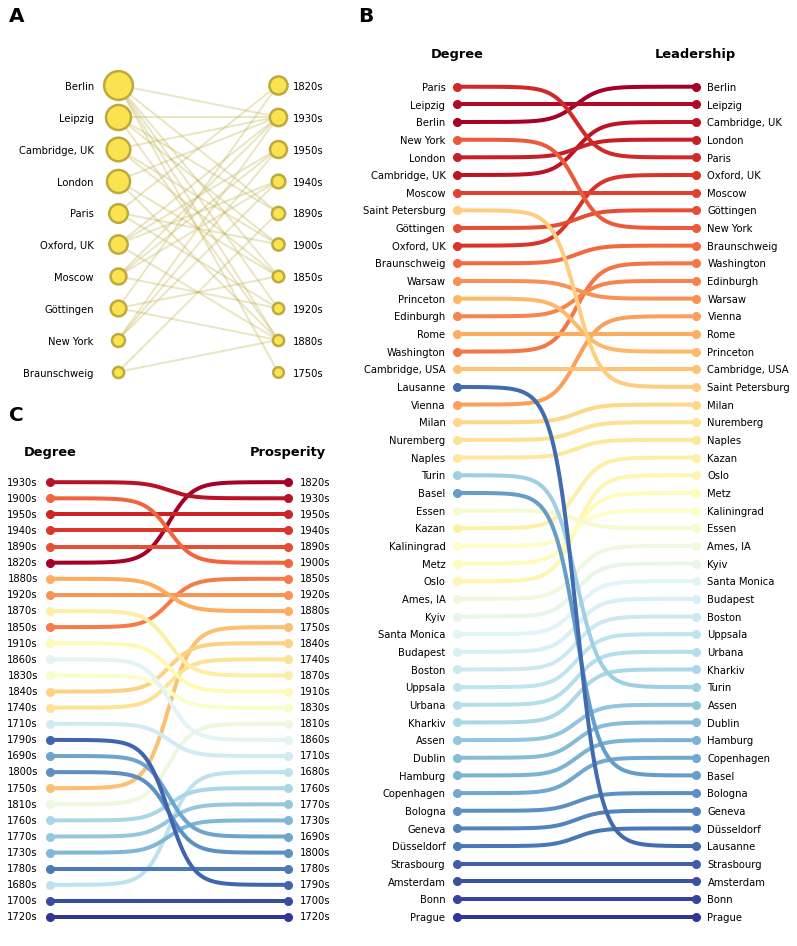

In [29]:
fig = plt.figure(figsize=(12, 16))
grid = plt.GridSpec(16, 12, wspace=1, hspace=0.8)
ax3 = fig.add_subplot(grid[0:8, 0:6])
for i in range(len(G10000)):
    ax3.plot(G10000[['0','1']].T[i]*4, '-', linewidth=2, color='#BCAA3D', alpha=0.3)
for i in range(10):
    ax3.text(-0.15, F_city1.T[F_city1.index[i]][1]*4+0.5, F_city1.index[i], horizontalalignment='right')
    ax3.text(1.09, Q_year1.T[Q_year1.index[i]][1]*4+0.5, Q_year1.index[i], horizontalalignment='left')
    ax3.plot(F_city1.T[F_city1.index[i]][1]*4, 'o', label=F_city1.index[i], markersize=list(city_rank['Fitness'])[i]*8, color='#FBE251', markeredgecolor='#BCAA3D', markeredgewidth=2.5)
    ax3.plot(1, Q_year1.T[Q_year1.index[i]][1]*4, 'o', label=Q_year1.index[i], markersize=list(year_rank['Complexity'])[i]*8, color='#FBE251', markeredgecolor='#BCAA3D', markeredgewidth=2.5)
ax3.set_xlim(-0.5,1.5)
ax3.set_ylim(2,55)
ax3.invert_yaxis()
ax3.get_yaxis().set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.set_xticks([])
ax3.text(-0.68, -4, 'A', size=20, weight='bold')
ax3.text(1.5, -4, 'B', size=20, weight='bold')
ax3.text(-0.68, 46, 'C', size=20, weight='bold')
ax1 = fig.add_subplot(grid[0:16, 7:12])
for i in range(len(city_ranklist)):
    ax1.text(-0.05, city_rank1[city_ranklist[i]][0]+0.18, city_ranklist[i], horizontalalignment='right')
    ax1.text(1.05, city_rank1[city_ranklist[i]][1]+0.18, city_ranklist[i], horizontalalignment='left')
    ax1.plot(S1[city_ranklist[i]], '-', label=city_ranklist[i], linewidth=4, color=cmap1(i))
    ax1.plot(city_rank1[city_ranklist[i]][0], 'o', label=city_ranklist[i], markersize=8, color=cmap1(i))
    ax1.plot(1, city_rank1[city_ranklist[i]][1], 'o', label=city_ranklist[i], markersize=8, color=cmap1(i))
ax1.text(0, -0.7, 'Degree', horizontalalignment='center', size=13, weight='bold')
ax1.text(1, -0.7, 'Leadership', horizontalalignment='center', size=13, weight='bold')
ax1.set_ylim(0,len(city_ranklist)+1.25)
ax1.invert_yaxis()
ax1.get_yaxis().set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.set_xticks([]) 
ax2 = fig.add_subplot(grid[7:16, 0:5])
for i in range(len(year_ranklist)):
    ax2.text(-0.05, year_rank1[year_ranklist[i]][0]+0.15, year_ranklist[i], horizontalalignment='right')
    ax2.text(1.05, year_rank1[year_ranklist[i]][1]+0.15, year_ranklist[i], horizontalalignment='left')
    ax2.plot(S3[year_ranklist[i]], '-', label=year_ranklist[i], linewidth=4, color=cmap2(i))
    ax2.plot(year_rank1[year_ranklist[i]][0], 'o', label=year_ranklist[i], markersize=8, color=cmap2(i))
    ax2.plot(1, year_rank1[year_ranklist[i]][1], 'o', label=year_ranklist[i], markersize=8, color=cmap2(i))
ax2.text(0, -0.7, 'Degree', horizontalalignment='center', size=13, weight='bold')
ax2.text(1, -0.7, 'Prosperity', horizontalalignment='center', size=13, weight='bold')
ax2.invert_yaxis()
ax2.get_yaxis().set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.set_xticks([]) 
plt.savefig('your path\\figure5.pdf', format='pdf', bbox_inches='tight', dpi=300)